## Verification of Two Model Forecasts vs Observations (Measurements)

Documentation about DMI dat and Scores can be found here:
- https://opendatadocs.dmi.govcloud.dk/APIs/Meteorological_Observation_API
- https://scores.readthedocs.io/en/stable/index.html

Plese define the folling variables to define the data you want to verify. Each model var must have a corresponding obs var after processing.

In [1]:
path_model_1 = (
    "/users/sadamov/pyprojects/neural-lam/data/danra/single_levels.zarr"
)
path_model_2 = path_model_1  # Using same data for demonstration
url_model = (
    "https://mllam-test-data.s3.eu-north-1.amazonaws.com/single_levels.zarr"
)
vars_model = [
    "u10m",
    "v10m",
    "t2m",
    "pres_seasurface",
    "pres0m",
]

path_obs = "/users/sadamov/pyprojects/neural-lam/data/danra/observations.zarr"
url_obs = "https://dmigw.govcloud.dk/v2/metObs/collections/observation/items"
vars_obs = [
    "wind_speed_past1h",
    "wind_dir_past1h",
    "temp_dry",
    "pressure_at_sea",
    "pressure",
]
api_key = "8dff599e-9a48-46eb-a166-72f2f722645e"

# Chose subset if needed
vars_plot = vars_model

In [2]:
class SynopProcessor:
    def __init__(self):
        self.var_mapping = {
            "temp_dry": "t2m",
            "pressure_at_sea": "pres_seasurface",
            "pressure": "pres0m",
        }

    def calculate_wind_components(
        self, ds, speed_var="wind_speed_past1h", dir_var="wind_dir_past1h"
    ):
        """Calculate u and v wind components from speed and direction."""
        ds = ds.copy()
        ds["u10m"] = ds[speed_var] * np.cos(np.radians(90 - ds[dir_var]))
        ds["v10m"] = ds[speed_var] * np.sin(np.radians(90 - ds[dir_var]))
        ds = ds.drop_vars([speed_var, dir_var])
        return ds

    def rename_variables(self, ds):
        """Rename variables according to mapping."""
        return ds.rename_vars(self.var_mapping)

    def convert_units(self, ds):
        """Convert temperature to Kelvin and pressure to Pa."""
        ds = ds.copy()
        # Convert temperature from Celsius to Kelvin
        if "temp_dry" in ds:
            ds["temp_dry"] = ds["temp_dry"] + 273.15

        # Convert pressure from hPa to Pa
        for pressure_var in ["pressure", "pressure_at_sea"]:
            if pressure_var in ds:
                ds[pressure_var] = ds[pressure_var] * 100
        return ds

    def process_dataset(self, ds):
        """Process the entire dataset with unit conversions, wind calculation and variable renaming."""
        ds = self.convert_units(ds)
        ds = self.calculate_wind_components(ds)
        ds = self.rename_variables(ds)
        return ds

In [3]:
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import xarray as xr
from scipy.interpolate import RBFInterpolator
from scipy.spatial import KDTree
from scipy.stats import gaussian_kde, wasserstein_distance
from scores.continuous import (
    mae,
    mse,
    rmse,
)
from scores.continuous.correlation import pearsonr

/users/sadamov/miniforge3/envs/neural-lam/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


For this example the model data is coming from the AWS bucket from DMI for the DANRA reanalysis.

In [4]:
# If the data is not available locally, download it from the cloud
if not os.path.exists(path_model_1):
    ds_model = xr.open_zarr(url_model)
    chunk_dict = {dim: -1 for dim in ds_model.dims if dim != "time"}
    chunk_dict["time"] = 20
    ds_model = ds_model.chunk(chunk_dict)

    for var in ds_model.variables:
        if "chunks" in ds_model[var].encoding:
            del ds_model[var].encoding["chunks"]

    ds_model.to_zarr(path_model_1, mode="w")
else:
    ds_model = xr.open_zarr(path_model_1)

# Adjust time for both models (simulating different forecast steps)
ds_model["time"] = (
    pd.to_datetime(ds_model["time"].values) + pd.DateOffset(years=30)
).to_numpy()
ds_model_1 = ds_model.isel(time=slice(1, None))[
    vars_model
]  # One timestep offset
ds_model_2 = ds_model.isel(time=slice(3, None))[
    vars_model
]  # Three timesteps offset
ds_model_1 = ds_model_1.assign_coords(
    time=ds_model.isel(time=slice(0, -1)).time
)
ds_model_2 = ds_model_2.assign_coords(
    time=ds_model.isel(time=slice(0, -3)).time
)

ds_model

<xarray.Dataset> Size: 10GB
Dimensions:          (time: 100, y: 589, x: 789)
Coordinates:
    lat              (y, x) float64 4MB dask.array<chunksize=(589, 789), meta=np.ndarray>
    lon              (y, x) float64 4MB dask.array<chunksize=(589, 789), meta=np.ndarray>
  * time             (time) datetime64[ns] 800B 2020-09-01 ... 2020-09-13T09:...
  * x                (x) float64 6kB -1.999e+06 -1.997e+06 ... -2.925e+04
  * y                (y) float64 5kB -6.095e+05 -6.07e+05 ... 8.58e+05 8.605e+05
Data variables: (12/27)
    cape_column      (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    cb_column        (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    ct_column        (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    grpl_column      (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    hcc0m            (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    icei0m           (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    ...               ...
    t0m              (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    t2m              (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    u10m             (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    v10m             (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    vis0m            (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
    xhail0m          (time, y, x) float64 372MB dask.array<chunksize=(20, 589, 789), meta=np.ndarray>
Attributes:
    description:  All prognostic variables for 10-year period on reduced levels

The observations and model data must cover the same timesteps.
Since the example model data hosted on AWS is from 1990 some observations are not available.
For that reason the model data was artificially offset to the year 2020.

In [5]:
datetime_start = np.datetime_as_string(ds_model.time.values[0], unit="s")
datetime_end = np.datetime_as_string(ds_model.time.values[-1], unit="s")
datetime_range = f"{datetime_start}Z/{datetime_end}Z"
print(datetime_range)

2020-09-01T00:00:00Z/2020-09-13T09:00:00Z


In [6]:
dfs = {}

for var in vars_obs:
    params = {
        "api-key": api_key,
        "datetime": datetime_range,
        "parameterId": var,
        "bbox": "7,54,16,58",  # Bounding box for Denmark
        "limit": 100000,
    }

    # Fetch the data
    response = requests.get(url_obs, params=params)
    data = response.json()
    gdf = gpd.GeoDataFrame.from_features(data["features"])
    gdf["time"] = pd.to_datetime(gdf["observed"], utc=True)
    df_pivot = gdf.pivot(index="time", columns="stationId", values="value")
    dfs[var] = df_pivot

In [7]:
# Get the set of stations for each variable
station_sets = [set(dfs[var].columns) for var in vars_obs]

# Find common stations across all variables using set intersection
common_stations = set.intersection(*station_sets)

# Convert to sorted list if needed
common_stations = sorted(list(common_stations))

# Print the number of common stations and their IDs
print(f"Number of stations with data for all variables: {len(common_stations)}")
print("\nStation IDs:")
print(common_stations)

# Filter your DataFrames to keep only common stations
dfs_filtered = {}
for var in vars_obs:
    dfs_filtered[var] = dfs[var][common_stations]
# filter gdf by stations as well
gdf_filtered = gdf[gdf["stationId"].isin(common_stations)]

Number of stations with data for all variables: 48

Station IDs:
['06030', '06032', '06041', '06049', '06052', '06056', '06058', '06060', '06065', '06068', '06070', '06072', '06073', '06074', '06079', '06080', '06081', '06093', '06096', '06102', '06104', '06108', '06110', '06116', '06118', '06119', '06120', '06123', '06124', '06126', '06135', '06138', '06141', '06147', '06149', '06151', '06154', '06156', '06159', '06168', '06169', '06170', '06174', '06180', '06181', '06183', '06188', '06190']


In [8]:
# Convert model times to UTC datetime (assuming ds_model is available)
model_times = pd.to_datetime(ds_model["time"].values).tz_localize("UTC")
# Filter each DataFrame in the dictionary
# Assuming the DataFrames in dfs_filtered already have datetime index
dfs_filtered = {
    k: v[v.index.isin(model_times)] for k, v in dfs_filtered.items()
}
# Filter gdf_filtered
gdf_filtered = gdf_filtered.set_index("time")
gdf_filtered = gdf_filtered[gdf_filtered.index.isin(model_times)]

In [9]:
# Combine the DataFrames into a single xarray Dataset
ds_obs = xr.Dataset(
    {
        var: (["time", "stationId"], dfs_filtered[var].values)
        for var in vars_obs
    },
    coords={
        "time": ds_model.time,
        "stationId": dfs_filtered[vars_obs[0]].columns,
        "lat": (
            "stationId",
            gdf_filtered.groupby("stationId")["geometry"].first().y,
        ),
        "lon": (
            "stationId",
            gdf_filtered.groupby("stationId")["geometry"].first().x,
        ),
    },
)

ds_obs = ds_obs.sel(time=ds_model.time)
ds_obs = ds_obs.sortby("time")
ds_obs

<xarray.Dataset> Size: 194kB
Dimensions:            (time: 100, stationId: 48)
Coordinates:
  * time               (time) datetime64[ns] 800B 2020-09-01 ... 2020-09-13T0...
  * stationId          (stationId) object 384B '06030' '06032' ... '06190'
    lat                (stationId) float64 384B 57.1 57.38 57.74 ... 55.88 55.07
    lon                (stationId) float64 384B 9.851 10.33 ... 12.41 14.75
Data variables:
    wind_speed_past1h  (time, stationId) float64 38kB 1.0 0.3 2.5 ... 3.1 8.2
    wind_dir_past1h    (time, stationId) float64 38kB 62.0 352.0 ... 217.0 239.0
    temp_dry           (time, stationId) float64 38kB 9.1 8.5 12.4 ... 15.5 16.2
    pressure_at_sea    (time, stationId) float64 38kB 1.022e+03 ... 1.022e+03
    pressure           (time, stationId) float64 38kB 1.02e+03 ... 1.02e+03

Conversion of wind speed and direction to u and v.

In [10]:
processor = SynopProcessor()
ds_obs = processor.process_dataset(ds_obs)

Plotting of selected variable

In [11]:
date = ds_obs.isel(time=0)["time"].values
formatted_datetime = pd.to_datetime(date)
formatted_date = formatted_datetime.strftime("%Y-%m-%d")
hour = formatted_datetime.strftime("%H")

Visualization of the observations

In [12]:
ds_obs.isel(time=0)[vars_plot]

<xarray.Dataset> Size: 3kB
Dimensions:          (stationId: 48)
Coordinates:
    time             datetime64[ns] 8B 2020-09-01
  * stationId        (stationId) object 384B '06030' '06032' ... '06188' '06190'
    lat              (stationId) float64 384B 57.1 57.38 57.74 ... 55.88 55.07
    lon              (stationId) float64 384B 9.851 10.33 10.63 ... 12.41 14.75
Data variables:
    u10m             (stationId) float64 384B 0.8829 -0.04175 ... -0.3381 0.4724
    v10m             (stationId) float64 384B 0.4695 0.2971 ... 0.725 2.046
    t2m              (stationId) float64 384B 282.2 281.6 285.5 ... 281.3 nan
    pres_seasurface  (stationId) float64 384B 1.022e+05 1.022e+05 ... 1.019e+05
    pres0m           (stationId) float64 384B 1.02e+05 1.015e+05 ... 1.017e+05

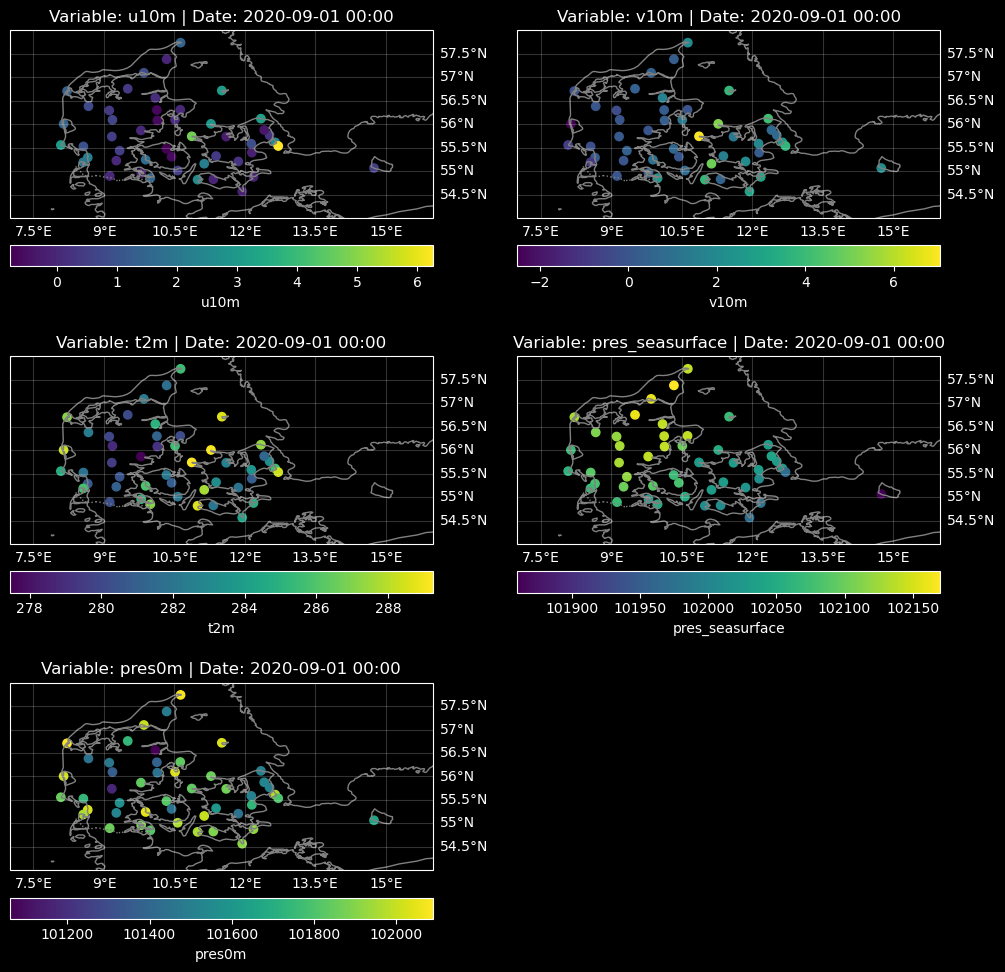

In [13]:
# Create single figure with 3x2 subplots
fig, axs = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 12),
    subplot_kw={"projection": ccrs.PlateCarree()},
)
axs = axs.flatten()  # Flatten 2D array of axes to 1D for easier iteration

# Loop through variables and corresponding subplots
for idx, var_plot in enumerate(vars_plot):
    ax = axs[idx]
    ax.set_extent([7, 16, 54, 58], crs=ccrs.PlateCarree())

    scatter = ax.scatter(
        ds_obs["lon"],
        ds_obs["lat"],
        c=ds_obs.isel(time=0)[var_plot],
        cmap="viridis",
        transform=ccrs.PlateCarree(),
    )

    ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
    ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="grey")
    ax.gridlines(draw_labels={"bottom": True, "right": True}, alpha=0.2)

    cbar = plt.colorbar(scatter, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(var_plot)

    ax.set_title(f"Variable: {var_plot} | Date: {formatted_date} {hour}:00")

# Hide empty subplots if fewer variables than subplot spaces
for idx in range(len(vars_plot), len(axs)):
    fig.delaxes(axs[idx])

plt.show()
plt.close()

Visualization of the model data

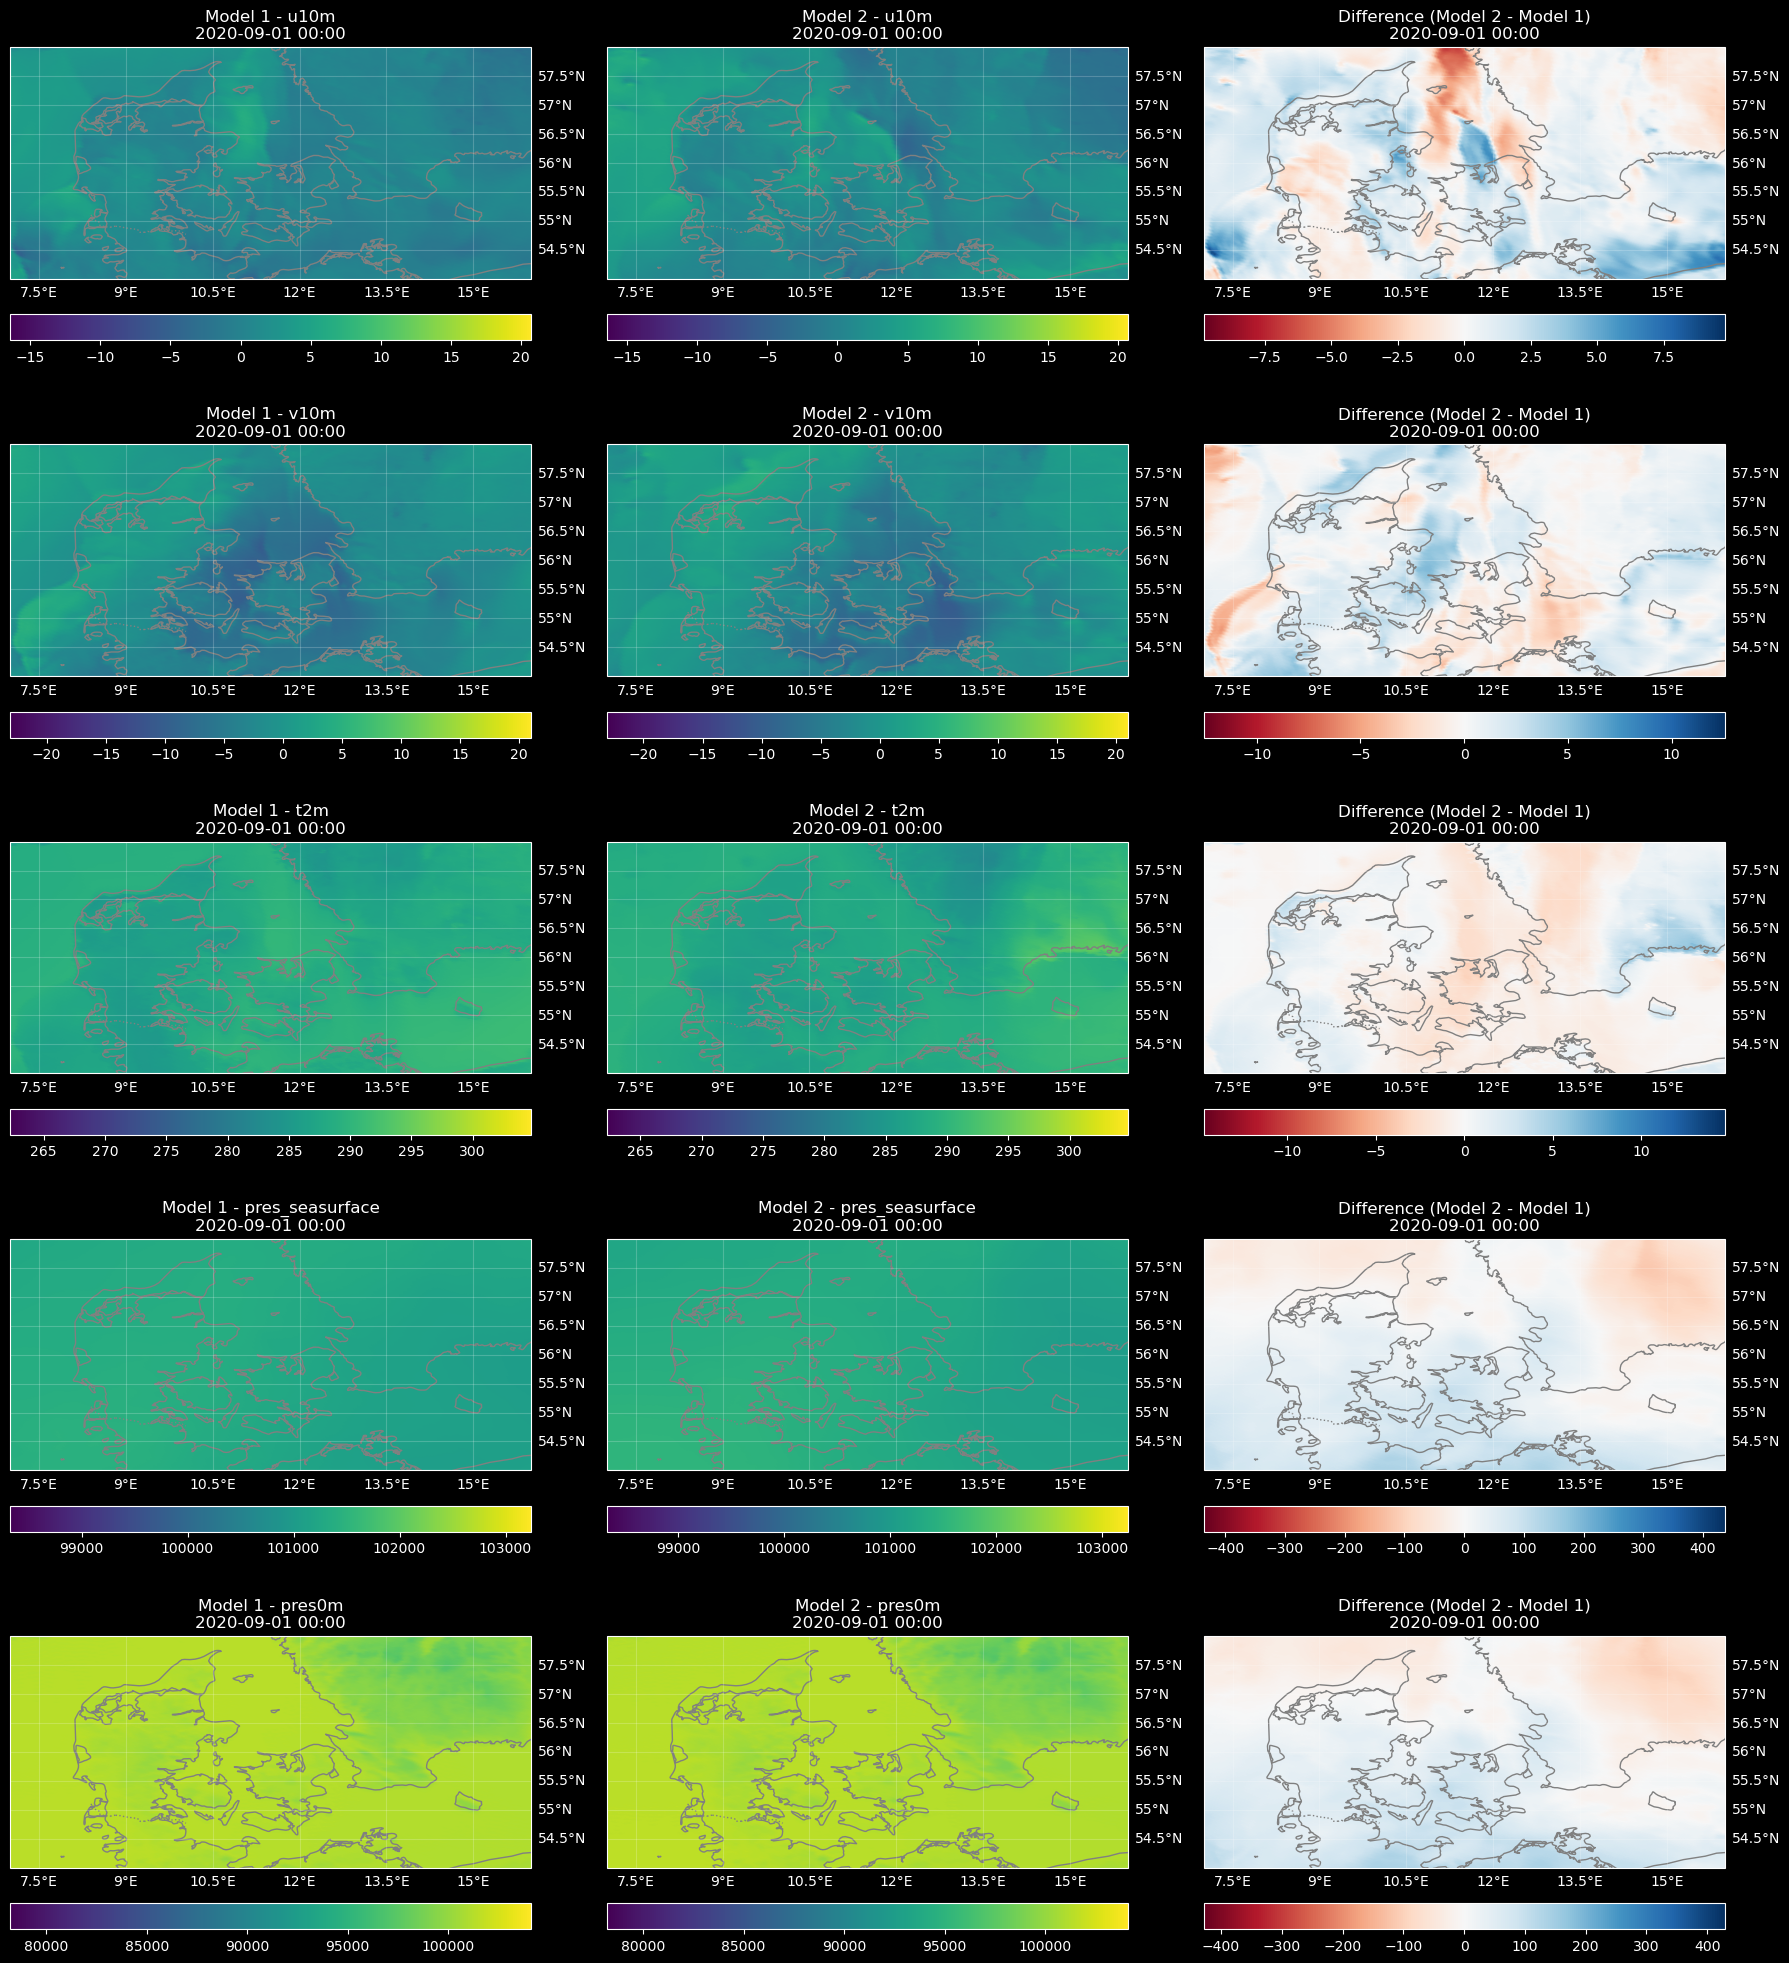

In [14]:
# Create single figure with 3x3 subplots (model 1 and model 2 side by side)
n_rows = len(vars_plot)
ds_model_1 = ds_model_1.compute()
ds_model_2 = ds_model_2.compute()

# Get global min/max values across all variables and both models
global_vmin = {}
global_vmax = {}
for var_plot in vars_plot:
    global_vmin[var_plot] = min(
        ds_model_1[var_plot].min(), ds_model_2[var_plot].min()
    )
    global_vmax[var_plot] = max(
        ds_model_1[var_plot].max(), ds_model_2[var_plot].max()
    )


fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=3,  # Keep 3 columns for obs, model 1, model 2
    figsize=(18, 4 * n_rows),  # Scale figure height with number of variables
    subplot_kw={"projection": ccrs.PlateCarree()},
)
# Plot each variable in a subplot
for idx, var_plot in enumerate(vars_plot):
    # Use global min/max values for this variable
    vmin = global_vmin[var_plot]
    vmax = global_vmax[var_plot]

    # Plot for Model 1
    ax1 = axs[idx, 0]
    ax1.set_extent([7, 16, 54, 58], crs=ccrs.PlateCarree())
    map1 = ax1.scatter(
        ds_model_1["lon"],
        ds_model_1["lat"],
        c=ds_model_1.isel(time=0)[var_plot],
        cmap="viridis",
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
    )
    ax1.add_feature(cfeature.COASTLINE, edgecolor="grey")
    ax1.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="grey")
    ax1.gridlines(draw_labels={"bottom": True, "right": True}, alpha=0.2)
    plt.colorbar(map1, ax=ax1, orientation="horizontal", pad=0.1)
    ax1.set_title(f"Model 1 - {var_plot}\n{formatted_date} {hour}:00")

    # Plot for Model 2
    ax2 = axs[idx, 1]
    ax2.set_extent([7, 16, 54, 58], crs=ccrs.PlateCarree())
    map2 = ax2.scatter(
        ds_model_2["lon"],
        ds_model_2["lat"],
        c=ds_model_2.isel(time=0)[var_plot],
        cmap="viridis",
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
    )
    ax2.add_feature(cfeature.COASTLINE, edgecolor="grey")
    ax2.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="grey")
    ax2.gridlines(draw_labels={"bottom": True, "right": True}, alpha=0.2)
    plt.colorbar(map2, ax=ax2, orientation="horizontal", pad=0.1)
    ax2.set_title(f"Model 2 - {var_plot}\n{formatted_date} {hour}:00")

    # Plot difference (Model 2 - Model 1)
    ax3 = axs[idx, 2]
    ax3.set_extent([7, 16, 54, 58], crs=ccrs.PlateCarree())
    diff = ds_model_2.isel(time=0)[var_plot] - ds_model_1.isel(time=0)[var_plot]
    vmax_diff = max(abs(diff.min()), abs(diff.max()))
    map3 = ax3.scatter(
        ds_model_2["lon"],
        ds_model_2["lat"],
        c=diff,
        cmap="RdBu",
        transform=ccrs.PlateCarree(),
        vmin=-vmax_diff,
        vmax=vmax_diff,
    )
    ax3.add_feature(cfeature.COASTLINE, edgecolor="grey")
    ax3.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="grey")
    ax3.gridlines(draw_labels={"bottom": True, "right": True}, alpha=0.2)
    plt.colorbar(map3, ax=ax3, orientation="horizontal", pad=0.1)
    ax3.set_title(f"Difference (Model 2 - Model 1)\n{formatted_date} {hour}:00")

plt.tight_layout()
plt.show()
plt.close()

Interpolation of the model data (gridded) to the observation points.
There are many methods for this, but for this example we will use linear RBF interpolation.

In [15]:
# After creating ds_model_1 and ds_model_2, align time dimensions with ds_obs
common_times = pd.Index(ds_obs.time.values).intersection(
    pd.Index(ds_model_1.time.values).intersection(
        pd.Index(ds_model_2.time.values)
    )
)

def interpolate_to_obs(
    ds_model_1, ds_model_2, ds_obs, vars_plot, neighbors=None
):
    """Interpolate both model datasets to observation points."""
    # Extract observation coordinates
    lats_obs = ds_obs.lat.values
    lons_obs = ds_obs.lon.values
    points_obs = np.column_stack((lons_obs, lats_obs))

    # Extract model coordinates (assuming same grid for both models)
    lats_model = ds_model_1.lat.values
    lons_model = ds_model_1.lon.values
    points_model = np.column_stack((lons_model.ravel(), lats_model.ravel()))

    interpolated_data_1 = {}
    interpolated_data_2 = {}

    for var in vars_plot:
        data_model_1 = ds_model_1[var].values
        data_model_2 = ds_model_2[var].values
        data_obs_shape = ds_obs[var].shape

        interpolated_values_1 = np.zeros(data_obs_shape)
        interpolated_values_2 = np.zeros(data_obs_shape)

        for t in range(
            min(len(ds_obs.time), len(ds_model_1.time), len(ds_model_2.time))
        ):
            # Model 1 interpolation
            data_slice_1 = data_model_1[t].flatten()
            valid_mask_1 = ~np.isnan(data_slice_1)
            if np.any(valid_mask_1):  # Only interpolate if we have valid data
                rbf_1 = RBFInterpolator(
                    points_model[valid_mask_1],
                    data_slice_1[valid_mask_1],
                    neighbors=neighbors,
                    kernel="linear",
                )
                interpolated_values_1[t] = rbf_1(points_obs)

            # Model 2 interpolation
            data_slice_2 = data_model_2[t].flatten()
            valid_mask_2 = ~np.isnan(data_slice_2)
            if np.any(valid_mask_2):  # Only interpolate if we have valid data
                rbf_2 = RBFInterpolator(
                    points_model[valid_mask_2],
                    data_slice_2[valid_mask_2],
                    neighbors=neighbors,
                    kernel="linear",
                )
                interpolated_values_2[t] = rbf_2(points_obs)

        interpolated_data_1[var] = xr.DataArray(
            interpolated_values_1,
            dims=["time", "stationId"],
            coords={"time": ds_obs.time, "stationId": ds_obs.stationId},
        )
        interpolated_data_2[var] = xr.DataArray(
            interpolated_values_2,
            dims=["time", "stationId"],
            coords={"time": ds_obs.time, "stationId": ds_obs.stationId},
        )

    return (xr.Dataset(interpolated_data_1), xr.Dataset(interpolated_data_2))


# Interpolate both models
ds_interpolated_1, ds_interpolated_2 = interpolate_to_obs(
    ds_model_1, ds_model_2, ds_obs, vars_plot, neighbors=10
)

Visualization of the interpolated model data

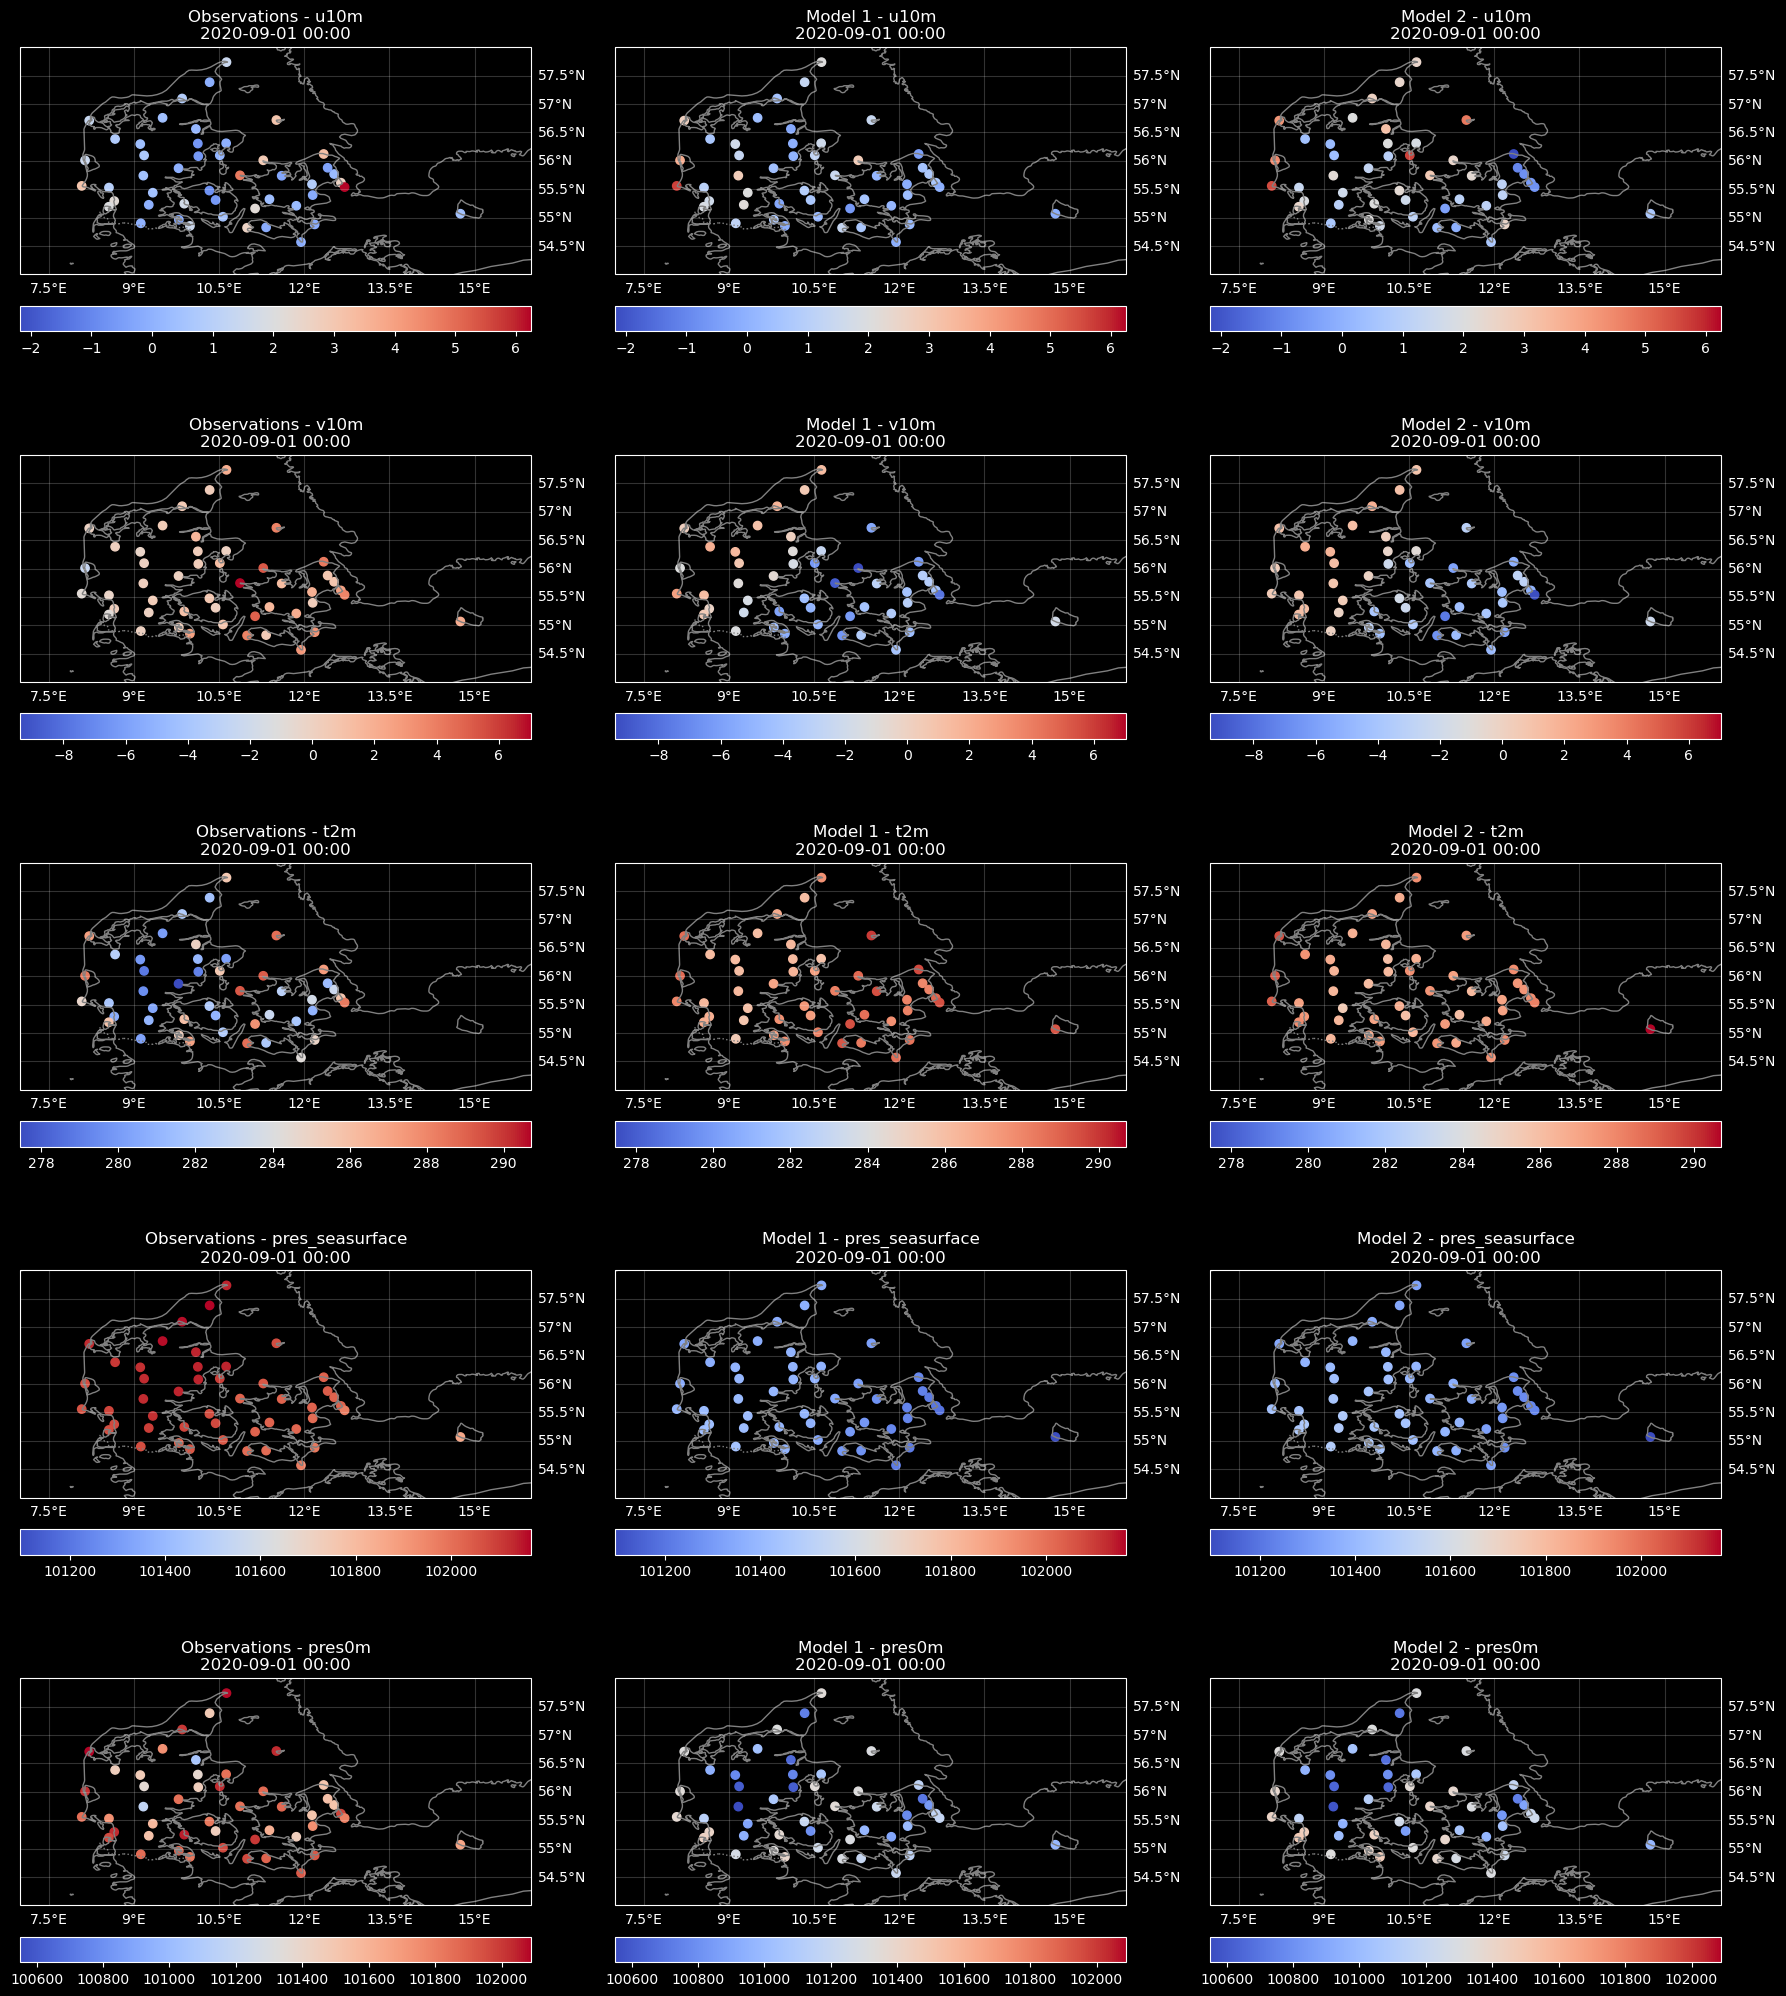

In [16]:
# Visualization of both interpolated model datasets
def plot_comparison(ds_obs, ds_interp_1, ds_interp_2, vars_plot, time_idx=0):
    fig, axs = plt.subplots(
        len(vars_plot),
        3,
        figsize=(18, 4* len(vars_plot)),
        subplot_kw={"projection": ccrs.PlateCarree()},
    )

    if len(vars_plot) == 1:
        axs = axs[np.newaxis, :]

    date = ds_obs.isel(time=time_idx)["time"].values
    formatted_datetime = pd.to_datetime(date)
    formatted_date = formatted_datetime.strftime("%Y-%m-%d")
    hour = formatted_datetime.strftime("%H")

    for idx, var_plot in enumerate(vars_plot):
        vmin = min(
            ds_obs[var_plot].isel(time=time_idx).min(),
            ds_interp_1[var_plot].isel(time=time_idx).min(),
            ds_interp_2[var_plot].isel(time=time_idx).min(),
        )
        vmax = max(
            ds_obs[var_plot].isel(time=time_idx).max(),
            ds_interp_1[var_plot].isel(time=time_idx).max(),
            ds_interp_2[var_plot].isel(time=time_idx).max(),
        )

        for ax_idx, (ax, data, title) in enumerate(
            zip(
                axs[idx],
                [ds_obs, ds_interp_1, ds_interp_2],
                ["Observations", "Model 1", "Model 2"],
            )
        ):
            ax.set_extent([7, 16, 54, 58], crs=ccrs.PlateCarree())

            scatter = ax.scatter(
                ds_obs["lon"],
                ds_obs["lat"],
                c=data.isel(time=time_idx)[var_plot],
                cmap="coolwarm",
                transform=ccrs.PlateCarree(),
                vmin=vmin,
                vmax=vmax,
            )

            ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
            ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="grey")
            ax.gridlines(draw_labels={"bottom": True, "right": True}, alpha=0.2)

            plt.colorbar(scatter, ax=ax, orientation="horizontal", pad=0.1)
            ax.set_title(f"{title} - {var_plot}\n{formatted_date} {hour}:00")

    plt.tight_layout()
    return fig


# Plot comparison
fig = plot_comparison(ds_obs, ds_interpolated_1, ds_interpolated_2, vars_plot)
plt.subplots_adjust(hspace=0.3)
plt.show()

For the verification with scores the data must contain lat and lon as xarray dimensions.
Here we use masked arrays for this purpose. There might be a better way to do this.

In [17]:
def convert_2d_to_3d(ds_2d, station_coords):
    lats = station_coords.y.values
    lons = station_coords.x.values
    time_index = ds_2d.time.values

    ds_3d = xr.Dataset()
    for var in ds_2d.data_vars:
        data_3d = np.full((len(time_index), len(lats), len(lons)), np.nan)
        for i, station in enumerate(ds_2d.stationId.values):
            lat_idx = np.where(lats == station_coords.loc[station].y)[0][0]
            lon_idx = np.where(lons == station_coords.loc[station].x)[0][0]
            data_3d[:, lat_idx, lon_idx] = (
                ds_2d[var].sel(stationId=station).values
            )

        ds_3d[var] = xr.DataArray(
            data=data_3d,
            dims=["time", "lat", "lon"],
            coords={
                "time": time_index,
                "lat": ("lat", lats),
                "lon": ("lon", lons),
            },
        )

    return ds_3d


# Convert ds_obs
ds_obs_3d = convert_2d_to_3d(
    ds_obs, gdf_filtered.groupby("stationId")["geometry"].first()
)

# Convert ds_interpolated
ds_interpolated_1_3d = convert_2d_to_3d(
    ds_interpolated_1, gdf_filtered.groupby("stationId")["geometry"].first()
)
ds_interpolated_2_3d = convert_2d_to_3d(
    ds_interpolated_2, gdf_filtered.groupby("stationId")["geometry"].first()
)

# Mask NaN values
masked_ds_obs_3d = ds_obs_3d.where(~np.isnan(ds_obs_3d), other=0)
masked_ds_interpolated_1_3d = ds_interpolated_1_3d.where(
    ~np.isnan(ds_interpolated_1_3d), other=0
)
masked_ds_interpolated_2_3d = ds_interpolated_2_3d.where(
    ~np.isnan(ds_interpolated_2_3d), other=0
)

Running the verification using the `scores` library.

In [18]:
def format_with_percent(val, col_name):
    """Format values with percentage for relative metrics"""
    if "Relative" in col_name:
        return f"{val:.6f}%"
    return f"{val:.4f}"


def calculate_all_metrics(
    ds_obs, ds_model_1, ds_model_2, vars_plot=vars_plot, calc_relative=True
):
    """Calculate metrics for both models against observations."""
    metrics_dict = {}

    for var in vars_plot:
        y_true = ds_obs[var]
        y_pred_1 = ds_model_1[var]
        y_pred_2 = ds_model_2[var]

        # Calculate norms
        l1_norm = np.sum(np.abs(y_true.values))
        l2_norm = np.sqrt(np.sum(y_true.values**2))

        # Calculate metrics for both models
        mae_val_1 = mae(y_true, y_pred_1)
        mae_val_2 = mae(y_true, y_pred_2)
        rmse_val_1 = rmse(y_true, y_pred_1)
        rmse_val_2 = rmse(y_true, y_pred_2)

        metrics_dict[var] = {
            "MAE Model 1": mae_val_1,
            "MAE Model 2": mae_val_2,
            "RMSE Model 1": rmse_val_1,
            "RMSE Model 2": rmse_val_2,
            "MSE Model 1": mse(y_true, y_pred_1),
            "MSE Model 2": mse(y_true, y_pred_2),
            "Pearson R Model 1": pearsonr(y_true, y_pred_1),
            "Pearson R Model 2": pearsonr(y_true, y_pred_2),
            "Wasserstein Model 1": wasserstein_distance(
                y_true.values.flatten(), y_pred_1.values.flatten()
            ),
            "Wasserstein Model 2": wasserstein_distance(
                y_true.values.flatten(), y_pred_2.values.flatten()
            ),
        }

        if calc_relative:
            metrics_dict[var].update({
                "Relative L1 Model 1 (%)": 100 * mae_val_1 / l1_norm,
                "Relative L1 Model 2 (%)": 100 * mae_val_2 / l1_norm,
                "Relative L2 Model 1 (%)": 100 * rmse_val_1 / l2_norm,
                "Relative L2 Model 2 (%)": 100 * rmse_val_2 / l2_norm,
            })

    return pd.DataFrame.from_dict(metrics_dict, orient="index")


# Calculate metrics for both models
metrics = calculate_all_metrics(
    masked_ds_obs_3d,
    masked_ds_interpolated_1_3d,
    masked_ds_interpolated_2_3d,
    calc_relative=True,
)

# Display metrics with formatting
formatters = {col: lambda x: f"{x:.4f}" for col in metrics.columns}
display(metrics.style.format(formatters))

,MAE Model 1,MAE Model 2,RMSE Model 1,RMSE Model 2,MSE Model 1,MSE Model 2,Pearson R Model 1,Pearson R Model 2,Wasserstein Model 1,Wasserstein Model 2,Relative L1 Model 1 (%),Relative L1 Model 2 (%),Relative L2 Model 1 (%),Relative L2 Model 2 (%)
u10m,0.1081,0.1113,0.9802,0.9894,0.9608,0.9789,-0.2407,-0.2585,0.0953,0.0962,0.0005,0.0006,0.2766,0.2791
v10m,0.0822,0.0812,0.7307,0.7198,0.5339,0.5182,-0.0058,0.0294,0.0147,0.0152,0.0007,0.0007,0.3313,0.3264
t2m,0.3620,0.3793,9.6075,9.6048,92.3036,92.2519,0.9719,0.9719,0.0515,0.0519,0.0000,0.0000,0.0488,0.0488
pres_seasurface,94.4198,93.9225,2899.4217,2899.5716,8406645.9325,8407515.4500,0.9797,0.9797,47.7350,47.5607,0.0000,0.0000,0.0414,0.0414
pres0m,93.8834,93.4236,2891.0999,2891.2578,8358458.4952,8359371.6727,0.9797,0.9797,45.9331,45.8771,0.0000,0.0000,0.0414,0.0414
